In [1]:
import pickle as pkl
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

import torch
import os
import copy

In [2]:

def add_mistakes_track(mistakes_summary,k,v):
    for k1,v1 in v.items():
        try:
            mistakes_summary[k][k1]['count'] += v1['count']
            mistakes_summary[k][k1]['cost_pred'] += v1['cost_pred']
            mistakes_summary[k][k1]['cost_max'] += v1['cost_max']
            mistakes_summary[k][k1]['cost_gt'] += v1['cost_gt']
            mistakes_summary[k][k1]['det_type_list'] += v1['det_type_list']
            try:
                mistakes_summary[k][k1]['track_type']['FP'] += v1['track_type']['FP']
                mistakes_summary[k][k1]['track_type']['TP'] += v1['track_type']['TP']
                mistakes_summary[k][k1]['track_type']['TP-OOR'] += v1['track_type']['TP-OOR']

            except KeyError:
                mistakes_summary[k][k1]['track_type'] = v1['track_type']
        except KeyError:
            mistakes_summary[k][k1] = v1
                    



def add_mistakes_det(mistakes_summary,k,v):
    for k1,v1 in v.items():
        try:
            mistakes_summary[k][k1]['count'] += v1['count']
            mistakes_summary[k][k1]['cost_pred'] += v1['cost_pred']
            mistakes_summary[k][k1]['cost_max'] += v1['cost_max']
            mistakes_summary[k][k1]['cost_gt'] += v1['cost_gt']
            mistakes_summary[k][k1]['det_type_list'] += v1['det_type_list']
            try:
                mistakes_summary[k][k1]['det_type']['FP'] += v1['det_type']['FP']
                mistakes_summary[k][k1]['det_type']['TP'] += v1['det_type']['TP']
            except KeyError:
                mistakes_summary[k][k1]['det_type'] = v1['det_type']
                
        except KeyError:
            mistakes_summary[k][k1] = v1
            
def get_mistakes_summary(all_log_vars):
    mistakes = [{k:v for k,v in x.items() if k.startswith('mistakes_')} for x in copy.deepcopy(all_log_vars)]
    mistakes = [x for x in mistakes if x != {}]
    mistakes_summary = {}
    for x in mistakes:
        for k,v in x.items():
            if k.startswith('mistakes_track_'):
                mistakes_summary[k] = mistakes_summary.get(k,{})
                add_mistakes_track(mistakes_summary,k,v)
            elif k.startswith('mistakes_det_'):
                mistakes_summary[k] = mistakes_summary.get(k,{})
                add_mistakes_det(mistakes_summary,k,v)
            elif k.startswith('mistakes_match_'):
                mistakes_summary[k] = mistakes_summary.get(k,0) + v

    for k,v in mistakes_summary.items():
        if k.startswith('mistakes_track_'):
            for k1,v1 in v.items():
                for key in ['cost_gt','cost_max','cost_pred']:
                    if mistakes_summary[k][k1][key][0].dim() == 1:
                         mistakes_summary[k][k1][key] = torch.cat( mistakes_summary[k][k1][key])
                    else:
                         mistakes_summary[k][k1][key] = torch.stack( mistakes_summary[k][k1][key])
        elif k.startswith('mistakes_det_'):
            for k1,v1 in v.items():
                for key in ['cost_gt','cost_max','cost_pred']:
                    if mistakes_summary[k][k1][key][0].dim() == 1:
                         mistakes_summary[k][k1][key] = torch.cat( mistakes_summary[k][k1][key])
                    else:
                         mistakes_summary[k][k1][key] = torch.stack( mistakes_summary[k][k1][key])
                            
        elif k.startswith('mistakes_match_'):
            pass
        
    return mistakes_summary


def get_metrics_summary(all_log_vars):

    metrics = [{k[5:]:v for k,v in x.items() if k.startswith('eval_')} for x in all_log_vars]
    metrics_summary = {}
    for x in metrics:
        for k,v in x.items():
            if k.startswith('mistakes_track_'):
                add_mistakes_track(metrics_summary,k,v)
            elif k.startswith('mistakes_det_'):
                add_mistakes_det(metrics_summary,k,v)

            elif type(v) == list:
                try:
                    metrics_summary[k].extend(v)
                except KeyError:
                    metrics_summary[k] = v

            elif type(v) == int or type(v) == float or type(v) == np.float64:
                if k.startswith('scene_'):
                    try:
                        metrics_summary[k[6:]].append(v)
                    except KeyError:
                        metrics_summary[k[6:]] = [v]
                else:
                    try:
                        metrics_summary[k] += v
                    except KeyError:
                        metrics_summary[k] = v
            else:
                print(type(v))


    for k,v in metrics_summary.items():
        if type(v) == list: 
            if type(v[0]) == torch.Tensor:
                metrics_summary[k] = torch.cat(v)
            else:
                metrics_summary[k] = torch.tensor(v,dtype=torch.float32)
                
    return metrics_summary


def get_metrics_from_summary(metrics_summary,suffix,detection_decisions,tracking_decisions):
    metrics = {}
    metrics[f'mean_track_length_{suffix}'] = torch.mean(metrics_summary[f'len_tracks'])
    metrics[f'median_track_length_{suffix}'] = torch.median(metrics_summary[f'len_tracks'])
    metrics[f'mean_track_length_>1_{suffix}'] = torch.mean(metrics_summary[f'greater_than_one_tracks'])
    metrics[f'Mean_tracks_per_scene_{suffix}'] = torch.mean(metrics_summary[f'total_tracks'])


    for k in ['total','det_match'] + detection_decisions + tracking_decisions:
        if k == 'total':
            metrics[f'acc_{k}_{suffix}'] = metrics_summary[k+'_correct'] / (metrics_summary[k+'_gt'] + 0.000000000001)
        else:
            metrics[f'recall_{k}_{suffix}'] = metrics_summary[k+'_correct'] / ( metrics_summary[k+'_gt'] + 0.000000000001)
            metrics[f'precision_{k}_{suffix}'] = metrics_summary[k+'_correct'] / ( metrics_summary[k+'_num_pred'] + 0.000000000001)

            add = metrics[f'recall_{k}_{suffix}'] + metrics[f'precision_{k}_{suffix}'] + 0.000000000001
            mul = metrics[f'recall_{k}_{suffix}'] * metrics[f'precision_{k}_{suffix}']
            metrics[f'f1_{k}_{suffix}'] = 2 * (mul/add)


    total_tp_decisions = torch.cat([x for k,x in metrics_summary.items() if k.startswith('num_TP')]).sum()
    for k in metrics_summary:

        if k in ['len_tracks','greater_than_one_tracks','total_tracks']:
            continue

        if k.startswith('num_TP') or k.startswith('num_dec'):
            metrics[f'%_{k[4:]}'] = metrics_summary[k].sum() / (total_tp_decisions + 0.000000000001)

        elif not ( k.endswith('_gt') or k.endswith('_correct') or k.endswith('_num_pred')):
            try:
                metrics[k] = metrics_summary[k].mean().item()
            except AttributeError:
                metrics[k] = np.mean(metrics_summary[k])



    for k,v in metrics.items():
        if type(v) == torch.Tensor:
            metrics[k] = round(v.item(),6)
        else:
            metrics[k] = round(v,6)

    if metrics['%_dec_track_unmatched'] == 0:
        del metrics['%_dec_track_unmatched']

    if metrics['%_dec_det_unmatched'] == 0: 
        del metrics['%_dec_det_unmatched']
        
    return metrics 



In [3]:
def get_text_summary_mistakes(mistakes_summary):
    trk_mistakes = [k for k in mistakes_summary.keys() if k.startswith('mistakes_track')]
    
    print("===================================================================")
    print("======================= Track Mistakes ============================")
    print("===================================================================")
    for outer_k in trk_mistakes:
        print("======================= [{}] =========================".format(outer_k))
        for k,v in mistakes_summary[outer_k].items():
            message = "GT: [{}] while pred: [{}]".format(k.replace('_',' ')," ".join(outer_k.split('_')[2:]))
            print(message)
            print('count:',v['count'])
            num_greedy_errors = len(torch.where(v['cost_gt'] - v['cost_max'] == 0.)[0])
            print('num_greedy_error:', num_greedy_errors)
            print('%_greedy_error:', round(num_greedy_errors/v['count'],3))
            print('track type:',v['track_type'])
            print('mean cost gt:',round(v['cost_gt'].mean().item(),4))
            print('mean cost pred:',round(v['cost_pred'].mean().item(),4))
            print('mean cost max:',round(v['cost_max'].mean().item(),4))
            print("================================================")
            
    print("===================================================================")
    print("======================= Detection Mistakes ========================")
    print("===================================================================") 
    det_mistakes = [k for k in mistakes_summary.keys() if k.startswith('mistakes_det')]
    for outer_k in [k for k in mistakes_summary.keys() if k.startswith('mistakes_det')]:
        print("======================= [{}] =========================".format(outer_k))
        for k,v in mistakes_summary[outer_k].items():
            message = "GT: [{}] pred: [{}]".format(k.replace('_',' ')," ".join(outer_k.split('_')[2:]))
            print(message)
            print('count:',v['count'])
            num_greedy_errors = len(torch.where(v['cost_gt'] - v['cost_max'] == 0.)[0])
            print('Hungarian error:', num_greedy_errors)
            print('%_Hungarian_error:', round(num_greedy_errors/v['count'],3))
            print('det type:',v['det_type'])
            print('mean cost gt:',round(v['cost_gt'].mean().item(),4))
            print('mean cost pred:',round(v['cost_pred'].mean().item(),4))
            print('mean cost max:',round(v['cost_max'].mean().item(),4))
            print("================================================")
            
def show_mistakes_ids_pct(mistakes_summary,savepath='/tmp/show_mistakes_ids_pct'):
    saved_plots = []
    
    mistakes_match = {k:v for k,v in mistakes_summary.items() if k.startswith('mistakes_match')}
    mistakes_match_w_fp_to = {k:v for k,v in mistakes_summary.items() \
                                  if k.startswith('mistakes_match') and 'FP_to' in k}
    
    mistakes_match_w_tp_to = {k:v for k,v in mistakes_summary.items() \
                                  if k.startswith('mistakes_match') and 'TP_to' in k}
    
    mistakes_match_w_to_fp = {k:v for k,v in mistakes_summary.items() \
                                  if k.startswith('mistakes_match') and 'to_FP' in k}
    
    mistakes_match_w_to_tp = {k:v for k,v in mistakes_summary.items() \
                                  if k.startswith('mistakes_match') and 'to_TP' in k}

    for i,(data,title) in enumerate([(mistakes_match,'Percentage of IDS types on validation set',),
                       (mistakes_match_w_fp_to,'Percentage of IDS types when the detection is FP'),
                       (mistakes_match_w_tp_to,'Percentage of IDS types when the detection is TP'),
                       (mistakes_match_w_to_fp,'Percentage of IDS types when the track is FP'),
                       (mistakes_match_w_to_tp,'Percentage of IDS types when the track is TP')]):

        #normalize values 
        total = sum(data.values())
        data = {" ".join(k.split('_')[-3:]):v/total \
                    for k,v in data.items()}

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = data.keys()
        sizes = data.values()
        explode = [0 if 'match' in x else 0 for x in data]   #(0, , 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots(figsize=(7,7))
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=False, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title(title, y=1.05)
        
        filepath = savepath+f"{i}.png"
        saved_plots.append(filepath)
        plt.savefig(filepath,bbox_inches='tight')
        plt.show()
    
    return saved_plots

In [6]:
def plot_track_length_frequency(metrics_summary,savepath='/tmp/plot_track_length_frequency'):
    saved_plots = []
    
    freq_all = np.bincount(metrics_summary['len_tracks'].long().numpy())
    freq_gt1 = np.bincount(metrics_summary['greater_than_one_tracks'].long().numpy())
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20,5))
    # Plot the frequencies as a bar chart
    ax.bar(np.arange(len(freq_all)), freq_all)
    ax.set_xticks(np.arange(len(freq_all)))
    ax.set_yscale('log')
    ax.set_title('Log scale chart of track length frequency')
    
    filepath = savepath+f"2.png"
    saved_plots.append(filepath)
    plt.savefig(filepath,bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20,5))
    # Plot the frequencies as a bar chart
    ax.bar(np.arange(len(freq_gt1)), freq_gt1)

    ax.set_xticks(np.arange(len(freq_all)))
    ax.set_title('Chart of track length frequency, excluding 1')
    ax.set_xticks(np.arange(len(freq_all)))
    
    filepath = savepath+f"2.png"
    saved_plots.append(filepath)
    plt.savefig(filepath,bbox_inches='tight')
    # Show the plot
    plt.show()
    
    return saved_plots
    
    

In [8]:
def show_metrics_decisions(metrics,savepath='/tmp/show_metrics_decisions'):
    f1_scores = {k:v for k,v in metrics.items() if k.startswith('f1_')}
    recall_scores = {k:v for k,v in metrics.items() if k.startswith('recall')}
    precision_scores = {k:v for k,v in metrics.items() if k.startswith('precision')}


    labels = [" ".join(k.split('_')[1:-1]).capitalize() for k in f1_scores]
    f1s = f1_scores.values()
    recalls = recall_scores.values()
    precisions = precision_scores.values()

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,6))
    rects1 = ax.bar(x - width, f1s, width, label='F1-Score')
    rects2 = ax.bar(x , recalls, width, label='Recall')
    rects3 = ax.bar(x + width, precisions, width, label='Precision')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('F1, Recall, and Precision Metrics for tracking decisions')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.set_xticklabels([0]+labels) 
    
    plt.xticks(rotation=30)
    fig.tight_layout()
    
    filepath = savepath+f".png"
    plt.savefig(filepath,bbox_inches='tight')
    plt.show()
    
    return [filepath]
    
def show_metrics_dec_pct(metrics,savepath='/tmp/show_metrics_dec_pct'):
    pct_tp = {k:v for k,v in metrics.items() if k.startswith('%_TP')}
    pct_tp_track = {k:v for k,v in metrics.items() if k.startswith('%_TP_track')}
    pct_tp_det = {k:v for k,v in metrics.items() if k.startswith('%_TP_det')}
    pct_pred = {k:v for k,v in metrics.items() if k.startswith('%_dec')}
    pct_pred_track = {k:v for k,v in metrics.items() if k.startswith('%_dec_track')}
    pct_pred_det = {k:v for k,v in metrics.items() if k.startswith('%_dec_det')}

    saved_plots = []
    for i,(data,title) in enumerate([(pct_tp,'All TP Dec'),
                                       (pct_tp_track,'All TP Track Dec'),
                                       (pct_tp_det,'All TP Det Dec'),
                                       (pct_pred,'All Pred Dec'),
                                       (pct_pred_track,'All Pred Track Dec'),
                                       (pct_pred_det,'All Pred Det Dec'),]):

        #normalize values 
        total = sum(data.values())
        data = {" ".join(k.split('_')[2:]).capitalize():v/total \
                    for k,v in data.items()}

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = data.keys()
        sizes = data.values()
        explode = [0 if 'match' in x else 0 for x in data]   #(0, , 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title(title, y=1.05)
        
        filepath = savepath+f"{i}.png"
        saved_plots.append(filepath)
        plt.savefig(filepath,bbox_inches='tight')
        plt.show()
        
    return saved_plots

======================= Track Mistakes ============================
======================= [mistakes_track_track_false_negative] =========================
GT: [match] while pred: [track false negative]
count: 25
num_greedy_error: 2
%_greedy_error: 0.08
track type: {'FP': 0, 'TP-OOR': 0, 'TP': 25}
mean cost gt: 0.2391
mean cost pred: 0.4087
mean cost max: 0.4272
GT: [track false positive] while pred: [track false negative]
count: 446
num_greedy_error: 0
%_greedy_error: 0.0
track type: {'FP': 420, 'TP-OOR': 26, 'TP': 0}
mean cost gt: 0.0302
mean cost pred: 0.5426
mean cost max: 0.5449
======================= [mistakes_track_track_false_positive] =========================
GT: [track false negative] while pred: [track false positive]
count: 3
num_greedy_error: 0
%_greedy_error: 0.0
track type: {'FP': 0, 'TP-OOR': 0, 'TP': 3}
mean cost gt: 0.0219
mean cost pred: 0.2506
mean cost max: 0.2506
GT: [match] while pred: [track false positive]
count: 14
num_greedy_error: 0
%_greedy_error: 0.0
tra

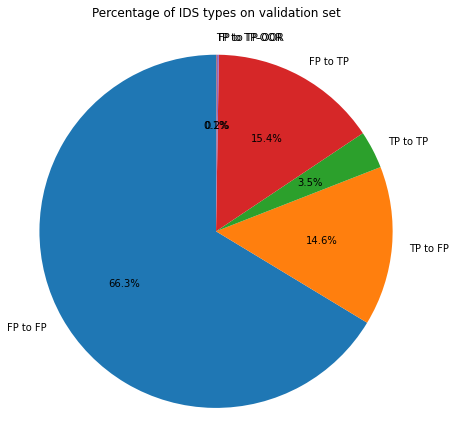

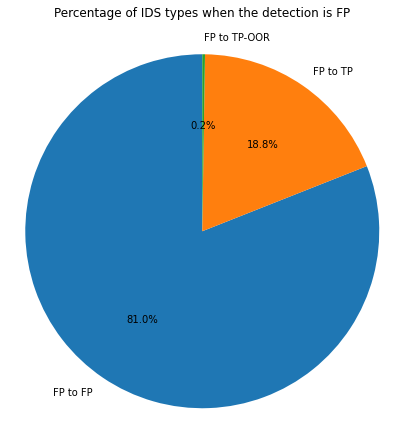

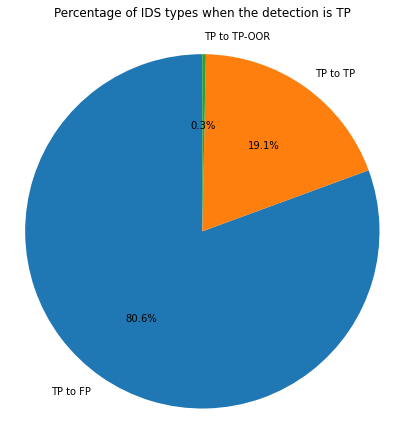

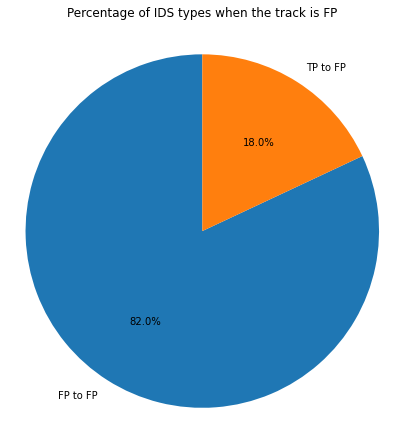

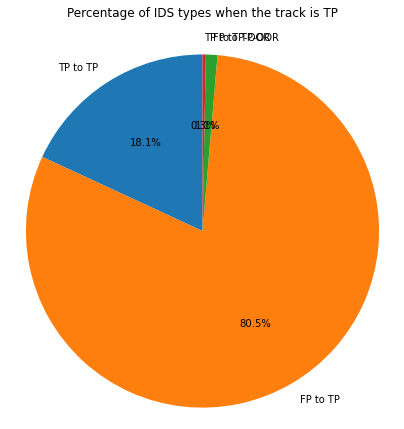

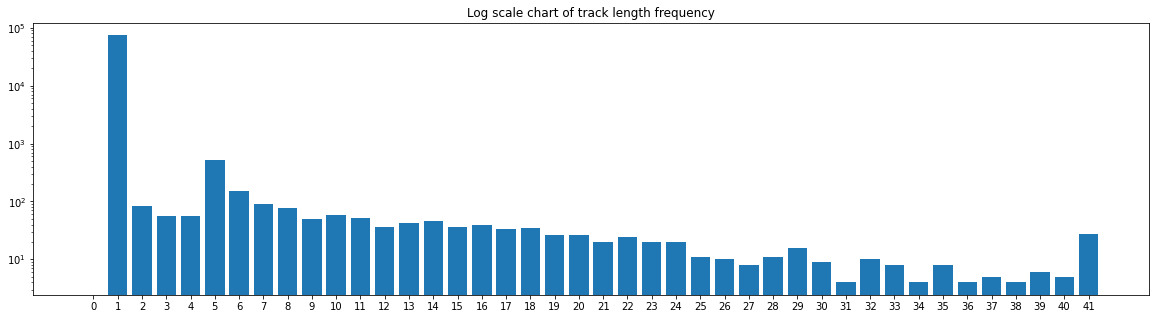

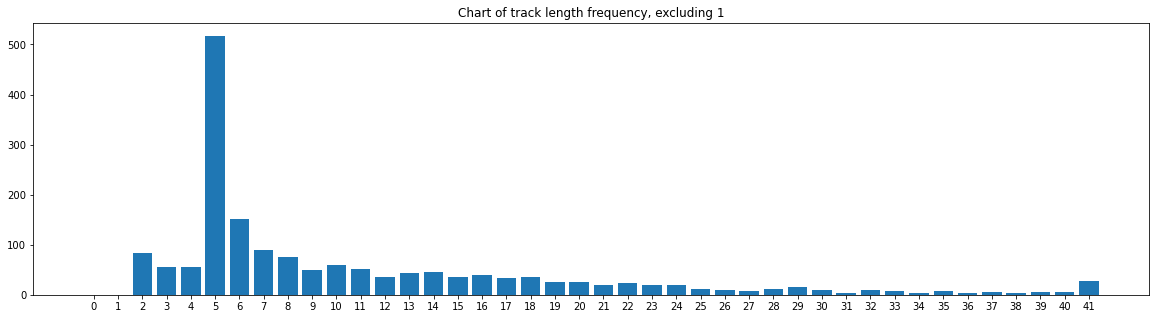

<ipython-input-8-de137333e854>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


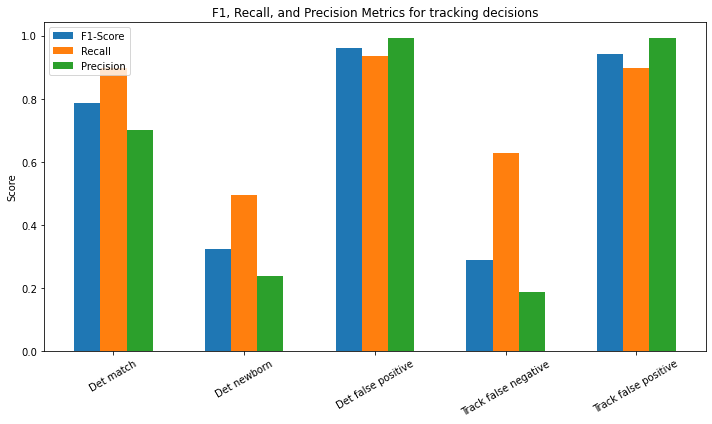

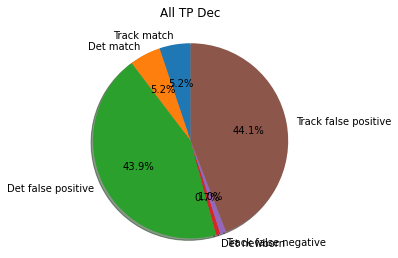

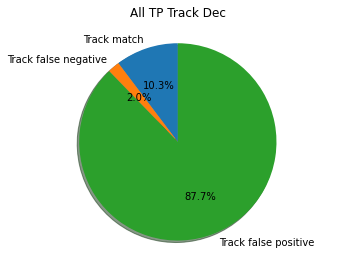

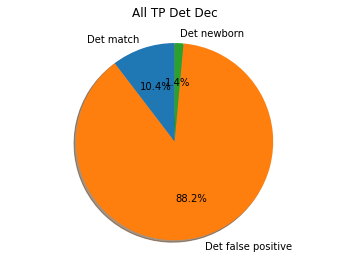

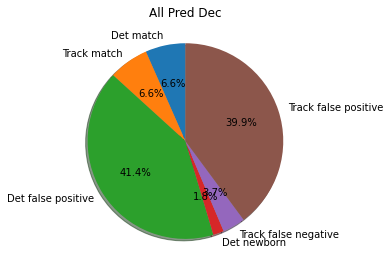

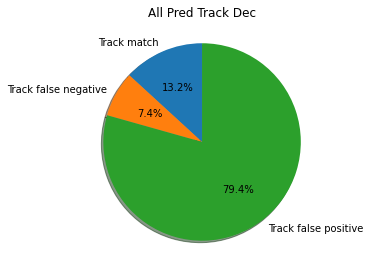

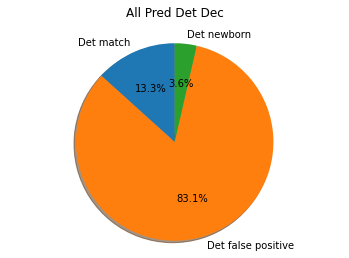

In [9]:
with open('all_log_vars.pkl','rb') as f:
    all_log_vars = pkl.load(f)
    
class Tracker():pass
tracker = Tracker()
tracker.cls ='All'
tracker.detection_decisions = ['det_newborn','det_false_positive']
tracker.tracking_decisions = ['track_false_negative','track_false_positive']

mistakes_summary = get_mistakes_summary(all_log_vars)
plots = []
get_text_summary_mistakes(mistakes_summary)
plots += show_mistakes_ids_pct(mistakes_summary)

metrics_summary = get_metrics_summary(all_log_vars)
metrics = get_metrics_from_summary(metrics_summary,tracker.cls,tracker.detection_decisions,tracker.tracking_decisions)

plots += plot_track_length_frequency(metrics_summary)
plots += show_metrics_decisions(metrics)
plots += show_metrics_dec_pct(metrics)

In [10]:
metrics

{'mean_track_length_All': 1.225049,
 'median_track_length_All': 1.0,
 'mean_track_length_>1_All': 10.743692,
 'Mean_tracks_per_scene_All': 3974.105225,
 'acc_total_All': 0.908804,
 'recall_det_match_All': 0.896929,
 'precision_det_match_All': 0.700457,
 'f1_det_match_All': 0.78661,
 'recall_det_newborn_All': 0.494014,
 'precision_det_newborn_All': 0.239366,
 'f1_det_newborn_All': 0.32248,
 'recall_det_false_positive_All': 0.934634,
 'precision_det_false_positive_All': 0.991505,
 'f1_det_false_positive_All': 0.96223,
 'recall_track_false_negative_All': 0.627746,
 'precision_track_false_negative_All': 0.188085,
 'f1_track_false_negative_All': 0.289446,
 'recall_track_false_positive_All': 0.897524,
 'precision_track_false_positive_All': 0.992232,
 'f1_track_false_positive_All': 0.942505,
 'mean_num_tracks_per_timestep': 112.865211,
 'mean_num_dets_per_timestep': 111.813866,
 '%_TP_track_match': 0.051718,
 '%_TP_det_match': 0.051718,
 '%_TP_det_false_positive': 0.438783,
 '%_TP_det_newborn

In [11]:
metrics_summary

{'total_correct': 150837,
 'total_gt': 165973.0000000002,
 'total_num_pred': 1.8999999999999996e-10,
 'det_match_correct': 8119,
 'det_match_gt': 9052.00000000019,
 'det_match_num_pred': 11591.000000000193,
 'det_false_positive_correct': 71778,
 'det_false_positive_gt': 76798.00000000019,
 'det_false_positive_num_pred': 72393.00000000017,
 'det_newborn_correct': 619,
 'det_newborn_gt': 1253.00000000019,
 'det_newborn_num_pred': 2586.00000000019,
 'track_false_negative_correct': 1086,
 'track_false_negative_gt': 1730.00000000019,
 'track_false_negative_num_pred': 5774.00000000019,
 'track_false_positive_correct': 69235,
 'track_false_positive_gt': 77140.00000000019,
 'track_false_positive_num_pred': 69777.00000000017,
 'mean_num_tracks_per_timestep': tensor([  0., 124., 129., 120., 146., 143., 140., 135., 134., 138., 138., 135.,
         141., 129., 133., 137., 153., 148., 146., 122., 136., 140., 148., 144.,
         140., 150., 145., 146., 137., 133., 135., 127., 138., 138., 123., 131.

In [12]:
metrics_summary['det_match_gt'] - metrics_summary['det_match_correct']

933.0000000001892

In [14]:
plots

['/tmp/show_mistakes_ids_pct0.png',
 '/tmp/show_mistakes_ids_pct1.png',
 '/tmp/show_mistakes_ids_pct2.png',
 '/tmp/show_mistakes_ids_pct3.png',
 '/tmp/show_mistakes_ids_pct4.png',
 '/tmp/plot_track_length_frequency2.png',
 '/tmp/plot_track_length_frequency2.png',
 <function __main__.show_metrics_decisions(metrics, savepath='/tmp/show_metrics_decisions')>,
 '/tmp/show_metrics_dec_pct0.png',
 '/tmp/show_metrics_dec_pct1.png',
 '/tmp/show_metrics_dec_pct2.png',
 '/tmp/show_metrics_dec_pct3.png',
 '/tmp/show_metrics_dec_pct4.png',
 '/tmp/show_metrics_dec_pct5.png']